In [32]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import pytorch_lightning as pl
import torch
from datetime import timedelta
from pytorch_forecasting import Baseline, GroupNormalizer, MultiNormalizer, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder, TorchNormalizer
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, MAPE, MAE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm

%matplotlib inline

# Preprocessing

In [2]:
%%time

df = pd.read_csv("data/data_preprocessed.csv")
df.head()

CPU times: user 17 ms, sys: 12.2 ms, total: 29.2 ms
Wall time: 27.9 ms


,Регион,Имя теста,date_day,sum,count
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0,1
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0,1
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0,2
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0,1
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0,1


In [3]:
df["date_day"] = pd.to_datetime(df["date_day"])
df["date_day"].min(), df["date_day"].max()

(Timestamp('2019-02-13 00:00:00'), Timestamp('2021-06-09 00:00:00'))

In [4]:
df.isnull().sum()

Регион       0
Имя теста    0
date_day     0
sum          0
count        0
dtype: int64

In [5]:
date_min = df["date_day"].min()
df['time_idx'] = df["date_day"].apply(lambda x: (x - date_min).days)

df['sum'] = df['sum'].astype(float)
df['count'] = df['count'].astype(float)

df["Номер месяца"] = df["date_day"].dt.month.astype(str).astype('category')
df["День недели"] = df["date_day"].dt.weekday.astype(str).astype('category')
df

,Регион,Имя теста,date_day,sum,count,time_idx,Номер месяца,День недели
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0.0,1.0,167,7,1
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0.0,1.0,437,4,5
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0.0,2.0,461,5,1
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0.0,1.0,535,8,5
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0.0,1.0,818,5,1
...,...,...,...,...,...,...,...,...
23464,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-29,0.0,2.0,836,5,5
23465,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-31,0.0,3.0,838,5,0
23466,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-03,0.0,2.0,841,6,3
23467,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-04,0.0,1.0,842,6,4


In [6]:
df['sum'].value_counts()

0.0      18370
1.0       2512
2.0        735
3.0        464
4.0        275
         ...  
93.0         1
116.0        1
134.0        1
111.0        1
99.0         1
Name: sum, Length: 124, dtype: int64

In [7]:
TEST_PERIOD = timedelta(days=14)
CUT_DATE = df["date_day"].max() - TEST_PERIOD
CUT_DATE

Timestamp('2021-05-26 00:00:00')

In [8]:
df_train = df[df["date_day"] <= CUT_DATE].reset_index(drop=True)
df_test = df[df["date_day"] > CUT_DATE].reset_index(drop=True)
df_train.shape, df_test.shape

((22240, 8), (1229, 8))

# Dataset creation

In [9]:
df_train.dtypes

Регион                  object
Имя теста               object
date_day        datetime64[ns]
sum                    float64
count                  float64
time_idx                 int64
Номер месяца          category
День недели           category
dtype: object

In [10]:
STATIC_CATEGORICALS = [
    'Регион', 'Имя теста'
]
STATIC_REALS = []
KNOWN_CATEGORICALS = ['Номер месяца', 'День недели']
KNOWN_REALS = ['time_idx']
UNKNOWN_REALS = ['sum']

In [11]:
df

,Регион,Имя теста,date_day,sum,count,time_idx,Номер месяца,День недели
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2019-07-30,0.0,1.0,167,7,1
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-04-25,0.0,1.0,437,4,5
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-05-19,0.0,2.0,461,5,1
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2020-08-01,0.0,1.0,535,8,5
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-05-11,0.0,1.0,818,5,1
...,...,...,...,...,...,...,...,...
23464,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-29,0.0,2.0,836,5,5
23465,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-05-31,0.0,3.0,838,5,0
23466,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-03,0.0,2.0,841,6,3
23467,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-04,0.0,1.0,842,6,4


In [12]:
training = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="sum",
    group_ids=["Регион", "Имя теста"],
    min_encoder_length=1,
    max_encoder_length=7*4,
    min_prediction_length=1,
    max_prediction_length=1,
    static_categoricals=STATIC_CATEGORICALS,
    static_reals=STATIC_REALS,
    time_varying_known_categoricals=KNOWN_CATEGORICALS,
    time_varying_known_reals=KNOWN_REALS,
    time_varying_unknown_reals=UNKNOWN_REALS,
    constant_fill_strategy={'sum': 0},
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    categorical_encoders={ft: NaNLabelEncoder(add_nan=True) for ft in KNOWN_CATEGORICALS},
    target_normalizer=GroupNormalizer(
        groups=["Регион", "Имя теста"], transformation="softplus"
    )
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training,
    df, # on inference, set df[df["Дата заказа"] <= INFERENCE_DATE]
#     min_encoder_length=7*10,
    min_prediction_idx=int(df_test['time_idx'].min()),
    predict=False, # on inference, set predict=True
    stop_randomization=True,
)

# create dataloaders for model
batch_size = 512  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=48, pin_memory=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=48, pin_memory=True)
print(f'Train dataset length: {len(training)}, train dataloader length: {len(train_dataloader)}')
print(f'Val dataset length: {len(validation)}, val dataloader length: {len(val_dataloader)}')

/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 12 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 7 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:621: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Регион': 'Еврейская АО', '__group_id__Имя теста': 'Borrelia burgdorferi s.l

Train dataset length: 29581, train dataloader length: 57
Val dataset length: 3814, val dataloader length: 8


/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 3 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:121: UserWarning: Found 7 unknown classes which were set to NaN
  UserWarning,
/home/user/conda/lib/python3.7/site-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 19 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Регион': 'Астраханская обл', '__group_id__Имя теста': 'Borrelia burgdorferi s.l (кач) ДНК'}, {'__group_id__Регион': 'Астраханская обл', '__group_id__Имя теста': 'Вирус клещевого энцефалита(кач) РНК'}, {'__group_id__Регион': 'Дагестан Респ', '__group_id__Имя теста': 'Borrelia burgdorferi s.l (кач) ДНК'},

In [13]:
training.decoded_index

,Регион,Имя теста,time_idx_first,time_idx_last,time_idx_first_prediction
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,437,461,461
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,818,829,829
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,827,829,829
3,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,535,551,551
4,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,813,829,829
...,...,...,...,...,...
29576,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,791,815,815
29577,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,794,821,821
29578,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,800,826,826
29579,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,800,827,827


In [14]:
validation.decoded_index

,Регион,Имя теста,time_idx_first,time_idx_last,time_idx_first_prediction
0,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,818,844,844
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,827,844,844
2,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,829,844,844
3,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,836,844,844
4,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,839,844,844
...,...,...,...,...,...
3809,Ярославская обл,Borrelia burgdorferi s.l (кач) ДНК,815,842,842
3810,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,812,835,835
3811,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,812,836,836
3812,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,812,838,838


In [15]:
sorted(validation.decoded_index['time_idx_last'].unique()), len(sorted(validation.decoded_index['time_idx_last'].unique()))

([834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847], 14)

In [16]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mae_rounded = mean_absolute_error(y_true, y_pred.round())
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mape_rounded = mean_absolute_percentage_error(y_true, y_pred.round())
    smape = SMAPE()(y_true, y_pred).item()
    smape_rounded = SMAPE()(y_true, y_pred.round()).item()
    print(f'MAE: {mae:.4f}, rounded: {mae_rounded:.4f}')
    print(f'MAPE: {mape:.4f}, rounded: {mape_rounded:.4f}')
    print(f'SMAPE: {smape:.4f}, rounded: {smape_rounded:.4f}')

In [17]:
print('Baseline predictions')
actuals = torch.cat([y for x, (y, _) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
calculate_metrics(actuals, baseline_predictions)

Baseline predictions
MAE: 1.6529, rounded: 1.6529
MAPE: 1799550494834688.0000, rounded: 1799550494834688.0000
SMAPE: 0.4824, rounded: 0.4824


In [18]:
inference_idx = validation.decoded_index[validation.decoded_index['time_idx_last'] == 847].index
len(inference_idx)

1061

In [19]:
calculate_metrics(actuals[inference_idx], baseline_predictions[inference_idx])

MAE: 4.3402, rounded: 4.3402
MAPE: 5165768694038528.0000, rounded: 5165768694038528.0000
SMAPE: 0.6708, rounded: 0.6708


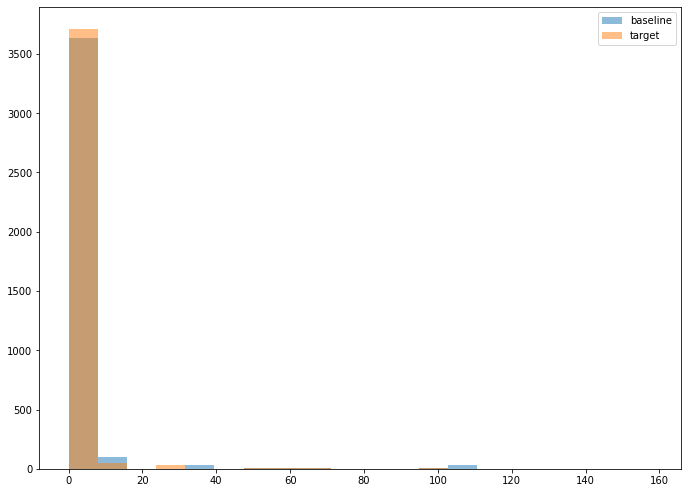

In [20]:
plt.figure(figsize=(11.5, 8.5))
plt.hist(baseline_predictions.numpy().ravel(), bins=20, alpha=0.5, label='baseline')
plt.hist(actuals.numpy().ravel(), bins=20, alpha=0.5, label='target')
plt.legend(loc='best')
plt.show()

# Training

In [21]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=20, verbose=False, mode="min")

# try:
#     lighting_logs_folder = f"logs-{environment}-{cfg.exp_name}"
# except:
#     lighting_logs_folder = f"logs-jupyter"
lighting_logs_folder = 'lightning_logs_sum'
lightning_logs_name = 'v03-mae-min_encoder_length-1'

pathlib.Path(os.path.join(lighting_logs_folder, lightning_logs_name)).mkdir(parents=True, exist_ok=True)

logger = TensorBoardLogger(lighting_logs_folder, name=lightning_logs_name)  # logging results to a tensorboard
print(f"TensorBoardLogger to {lighting_logs_folder}/{lightning_logs_name}")
lr_monitor = LearningRateMonitor(logging_interval='step')

# configure network and trainer
pl.seed_everything(13)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.5,
#     accumulate_grad_batches=4,
    max_epochs=1000,
    stochastic_weight_avg=True,
    callbacks=[early_stop_callback, lr_monitor],
    logger=logger
)

#     trainer = pl.Trainer(**cfg.trainer,
#                          callbacks=[early_stop_callback, lr_monitor],
#                          logger=logger
#                         )

tft = TemporalFusionTransformer.from_dataset(
    training,
#     weight_decay=0.1,
    learning_rate=0.001,
    hidden_size=8,
    lstm_layers=2,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=8,
    output_size=1,
    loss=MAE()
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 13
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


TensorBoardLogger to lightning_logs_sum/v03-mae-min_encoder_length-1
Number of parameters in network: 9.1k


In [ ]:
%%time
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 687   
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 916   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

/home/user/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/callback_hook.py:101: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  "The signature of `Callback.on_train_epoch_end` has changed in v1.3."


Validating: 0it [00:00, ?it/s]

/home/user/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Results

In [23]:
trainer.checkpoint_callback.best_model_path

'lightning_logs_sum/v03-mae-min_encoder_length-1/version_0/checkpoints/epoch=86-step=4958.ckpt'

In [24]:
# best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = 'lightning_logs_sum/v03-mae-min_encoder_length-1/version_0/checkpoints/epoch=86-step=4958.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path).cuda()

In [25]:
%%time

print('TFT predictions')
# actuals = torch.cat([y for x, (y, _) in iter(val_dataloader)])
tft_predictions = best_tft.predict(val_dataloader)
calculate_metrics(actuals, tft_predictions)

TFT predictions
MAE: 1.3540, rounded: 1.2412
MAPE: 2444768667762688.0000, rounded: 1955417139707904.0000
SMAPE: 1.7999, rounded: 0.8571
CPU times: user 1.41 s, sys: 7.73 s, total: 9.14 s
Wall time: 20.9 s


In [26]:
calculate_metrics(actuals[inference_idx], tft_predictions[inference_idx])

MAE: 2.5640, rounded: 2.5382
MAPE: 3391800366596096.0000, rounded: 3289622826188800.0000
SMAPE: 1.6846, rounded: 0.7742


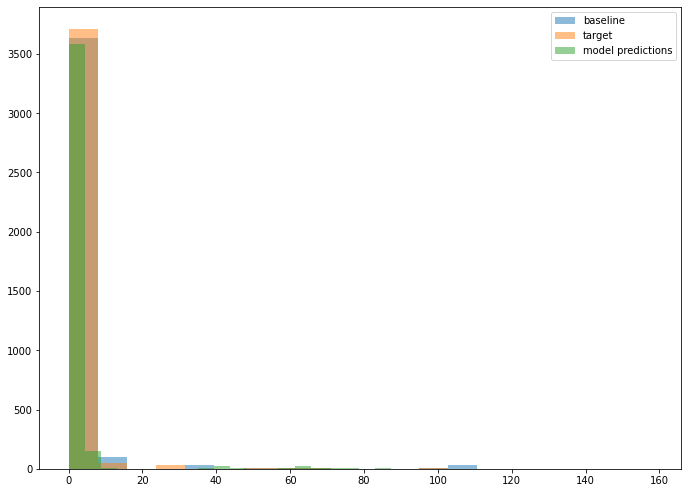

In [27]:
plt.figure(figsize=(11.5, 8.5))
plt.hist(baseline_predictions.numpy().ravel(), bins=20, alpha=0.5, label='baseline')
plt.hist(actuals.numpy().ravel(), bins=20, alpha=0.5, label='target')
plt.hist(tft_predictions.numpy().ravel(), bins=20, alpha=0.5, label='model predictions')
plt.legend(loc='best')
plt.show()

# Inference

In [28]:
INFERENCE_PREDICTION_LENGTH = 19
MAX_ENCODER_LENGTH = 28
INFERENCE_MIN_PREDICTION_IDX = 848
INFERENCE_DATES = pd.date_range('2021-06-09', '2021-06-27')
INFERENCE_MONTH = pd.Series([6] * INFERENCE_PREDICTION_LENGTH).astype(str).astype('category')
INFERENCE_WEEKDAY = pd.Series([x.weekday() for x in pd.date_range('2021-06-09', '2021-06-27')]).astype(str).astype('category')
INFERENCE_TIME_IDX = pd.Series(np.arange(INFERENCE_MIN_PREDICTION_IDX, INFERENCE_MIN_PREDICTION_IDX + INFERENCE_PREDICTION_LENGTH))

test_cols = [
    'Anaplasma Phagocytophillum(кач) ДНК',
    'Borrelia burgdorferi s.l (кач) ДНК',
    'Borrelia miyamotoi (кач) ДНК',
    'Ehrlichia muris/chaffeеnsis(кач) ДНК',
    'Вирус клещевого энцефалита(кач) РНК'
]

regions = sorted(df['Регион'].unique())
print('Total regions:', len(regions))
regions_submission_column = []
dates_submission_column = []
for r in regions:
    regions_submission_column += [r] * INFERENCE_PREDICTION_LENGTH
    dates_submission_column += INFERENCE_DATES

Total regions: 67


In [29]:
df_submission = pd.DataFrame({'region': regions_submission_column}, index=dates_submission_column)
df_submission

,region
2021-06-09,Адыгея Респ
2021-06-10,Адыгея Респ
2021-06-11,Адыгея Респ
2021-06-12,Адыгея Респ
2021-06-13,Адыгея Респ
...,...
2021-06-23,Ярославская обл
2021-06-24,Ярославская обл
2021-06-25,Ярославская обл
2021-06-26,Ярославская обл


In [30]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
errors = []
for test in test_cols:
    for region in tqdm(regions):
        df_region_test = df[(df['Регион'] == region) & (df['Имя теста'] == test)]
        if len(df_region_test) > 0:
            encoder_data = df_region_test[lambda x: x.time_idx > INFERENCE_MIN_PREDICTION_IDX - 1 - MAX_ENCODER_LENGTH]
            decoder_data = pd.DataFrame({
                'Регион': [region] * INFERENCE_PREDICTION_LENGTH,
                'Имя теста': [test] * INFERENCE_PREDICTION_LENGTH,
                'date_day': INFERENCE_DATES,
                'sum': 0.0,
                'time_idx': INFERENCE_TIME_IDX,
                'Номер месяца': INFERENCE_MONTH,
                'День недели': INFERENCE_WEEKDAY
            })
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
            one_pair = TimeSeriesDataSet.from_dataset(
                validation,
                new_prediction_data,
                stop_randomization=True,
                min_encoder_length=int(INFERENCE_MIN_PREDICTION_IDX - new_prediction_data['time_idx'].min()),
                min_prediction_idx=INFERENCE_MIN_PREDICTION_IDX,
                min_prediction_length=INFERENCE_PREDICTION_LENGTH,
                max_prediction_length=INFERENCE_PREDICTION_LENGTH
            )
            one_pair_dataloader = one_pair.to_dataloader(train=False, batch_size=1, num_workers=0)
            if len(one_pair_dataloader) != 1:
                errors.append((region, test, len(one_pair_dataloader)))
            predictions_one_pair = best_tft.predict(one_pair_dataloader).numpy().ravel()
            df_submission.loc[df_submission['region'] == region, test + ' sum'] = predictions_one_pair
        else:
            df_submission.loc[df_submission['region'] == region, test + ' sum'] = 0.0
print('Errors:')
print(errors)

100%|██████████| 67/67 [00:14<00:00,  4.50it/s]

Errors:
[]


In [34]:
df_submission

,region,Anaplasma Phagocytophillum(кач) ДНК sum,Borrelia burgdorferi s.l (кач) ДНК sum,Borrelia miyamotoi (кач) ДНК sum,Ehrlichia muris/chaffeеnsis(кач) ДНК sum,Вирус клещевого энцефалита(кач) РНК sum
2021-06-09,Адыгея Респ,0.0,0.033409,0.0,0.0,1.313262
2021-06-10,Адыгея Респ,0.0,0.033389,0.0,0.0,1.313262
2021-06-11,Адыгея Респ,0.0,0.033428,0.0,0.0,1.313262
2021-06-12,Адыгея Респ,0.0,0.033442,0.0,0.0,1.313262
2021-06-13,Адыгея Респ,0.0,0.033523,0.0,0.0,1.313262
...,...,...,...,...,...,...
2021-06-23,Ярославская обл,0.0,0.009962,0.0,0.0,1.313262
2021-06-24,Ярославская обл,0.0,0.010055,0.0,0.0,1.313262
2021-06-25,Ярославская обл,0.0,0.009997,0.0,0.0,1.313262
2021-06-26,Ярославская обл,0.0,0.010052,0.0,0.0,1.313262


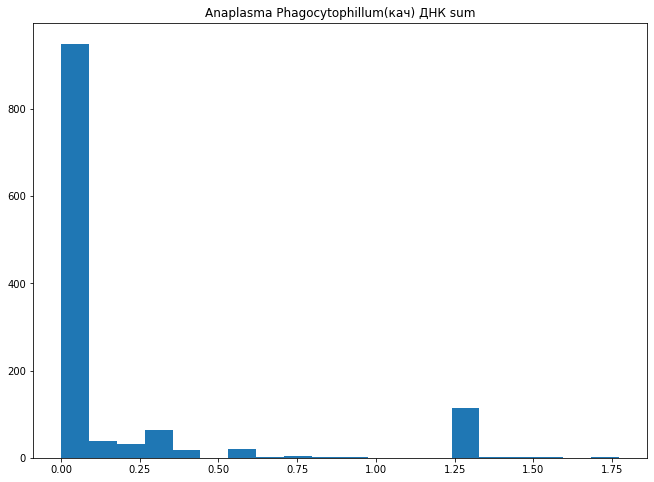

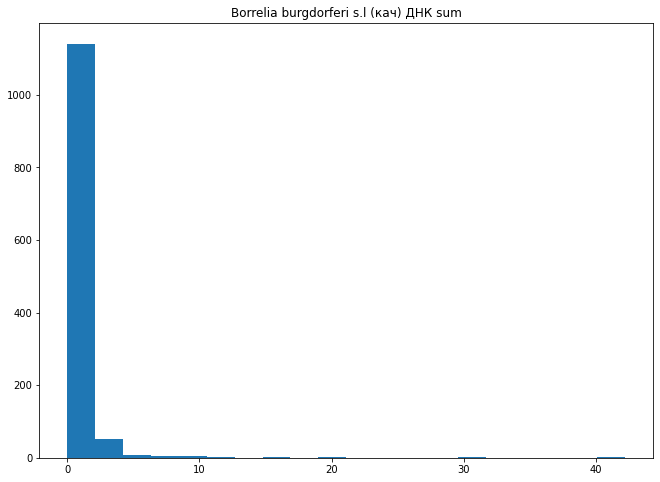

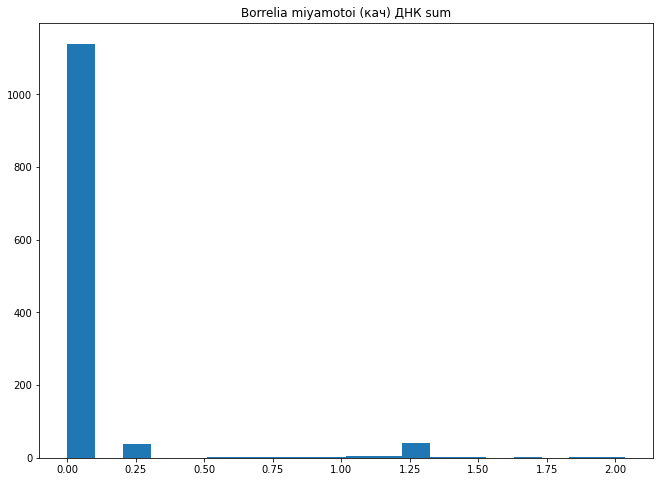

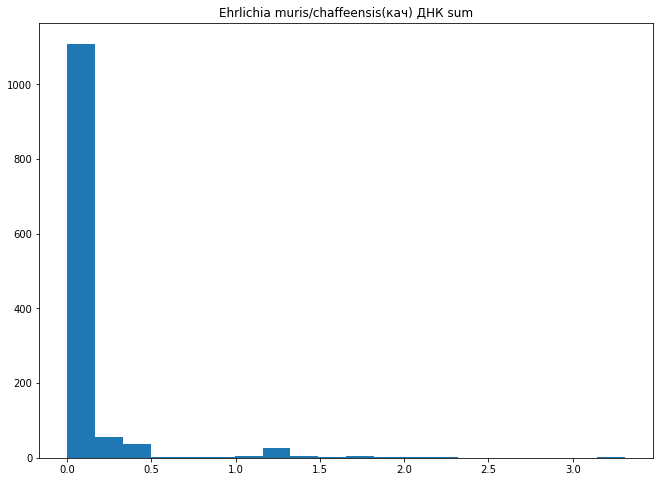

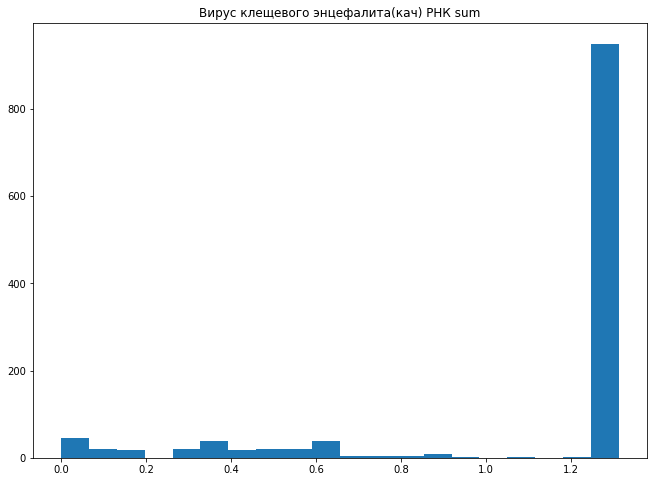

In [35]:
for col in df_submission.columns[1:]:
    plt.figure(figsize=(11, 8))
    plt.hist(df_submission[col], bins=20)
    plt.title(col)
    plt.show()

In [36]:
df_submission_sum_final = df_submission.round()
df_submission_sum_final.rename(columns={
    'Anaplasma Phagocytophillum(кач) ДНК percent_count': 'Anaplasma Phagocytophillum(кач) ДНК count',
    'Borrelia burgdorferi s.l (кач) ДНК percent_count': 'Borrelia burgdorferi s.l (кач) ДНК count',
    'Borrelia miyamotoi (кач) ДНК percent_count': 'Borrelia miyamotoi (кач) ДНК count',
    'Ehrlichia muris/chaffeеnsis(кач) ДНК percent_count': 'Ehrlichia muris/chaffeеnsis(кач) ДНК count',
    'Вирус клещевого энцефалита(кач) РНК percent_count': 'Вирус клещевого энцефалита(кач) РНК count'
}, inplace=True)
df_submission_sum_final

,region,Anaplasma Phagocytophillum(кач) ДНК sum,Borrelia burgdorferi s.l (кач) ДНК sum,Borrelia miyamotoi (кач) ДНК sum,Ehrlichia muris/chaffeеnsis(кач) ДНК sum,Вирус клещевого энцефалита(кач) РНК sum
2021-06-09,Адыгея Респ,0.0,0.0,0.0,0.0,1.0
2021-06-10,Адыгея Респ,0.0,0.0,0.0,0.0,1.0
2021-06-11,Адыгея Респ,0.0,0.0,0.0,0.0,1.0
2021-06-12,Адыгея Респ,0.0,0.0,0.0,0.0,1.0
2021-06-13,Адыгея Респ,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
2021-06-23,Ярославская обл,0.0,0.0,0.0,0.0,1.0
2021-06-24,Ярославская обл,0.0,0.0,0.0,0.0,1.0
2021-06-25,Ярославская обл,0.0,0.0,0.0,0.0,1.0
2021-06-26,Ярославская обл,0.0,0.0,0.0,0.0,1.0


In [37]:
df_submission_sum_final.to_csv('submissions/df_submission_sum_final.csv')